In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
# from sklearn.manifold import TSNE
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from random import randint
import seaborn as sns; sns.set_style("white")
import umap as umap

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

2023-08-30 09:13:10.369575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/scratch2-shared/david/colopaint3D/notebooks'

In [2]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./output/3_PCAUMAP_MeanMedian'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/1_FeaturesImages'


In [3]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    return ax.add_patch(ellipse)


In [4]:
###Medians
statmet = 'Median'
read_data = pd.read_parquet(f'{FeatureDir}/spheroid{statmet}.parquet')
cbar = pd.DataFrame()
read_data.reset_index(inplace=True, drop = True)
training_data = read_data.copy()
loc_data = training_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y']]
training_data = training_data.loc[:,~training_data.columns.str.contains('Location', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('ImageNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Parent', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Children', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_ObjectNumber', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Object_Number', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Y', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_X', case=True)]
##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]
target = pd.DataFrame()
onehot_val = list(range(len(training_data['Metadata_Cmpd'].unique())))
onehot_dict = dict(zip(training_data['Metadata_Cmpd'].unique(), onehot_val))
target['onehot'] = training_data['Metadata_Cmpd'].apply(lambda x: onehot_dict.get(x, -1))
training_data['onehot'] = target['onehot']
training_data = training_data.copy()



In [5]:
training_data.head()

,Metadata_Barcode,Metadata_Well,Metadata_Cmpd,Metadata_Site,Nuclei_AreaShape_Area,Nuclei_AreaShape_BoundingBoxArea,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_ConvexArea,Nuclei_AreaShape_Eccentricity,Nuclei_AreaShape_EquivalentDiameter,...,Cells_RadialDistribution_ZernikePhase_SYTO_8_2,Cells_RadialDistribution_ZernikePhase_SYTO_8_4,Cells_RadialDistribution_ZernikePhase_SYTO_8_6,Cells_RadialDistribution_ZernikePhase_SYTO_8_8,Cells_RadialDistribution_ZernikePhase_SYTO_9_1,Cells_RadialDistribution_ZernikePhase_SYTO_9_3,Cells_RadialDistribution_ZernikePhase_SYTO_9_5,Cells_RadialDistribution_ZernikePhase_SYTO_9_7,Cells_RadialDistribution_ZernikePhase_SYTO_9_9,onehot
0,pilot12-HCT116-day2,B02,etop,7.0,-0.848457,-0.796008,-0.532918,-0.850140,0.138806,-0.831716,...,0.309131,0.028306,-0.267119,0.452728,0.401375,-0.279519,-0.085565,-0.223884,-0.052186,0
1,pilot12-HCT116-day2,B03,berb,8.0,-0.226461,-0.224576,-0.412672,-0.248451,-0.128080,-0.101518,...,-0.011047,-0.016072,-0.217222,-0.037993,0.043704,0.110460,-0.072687,0.048304,0.120973,1
2,pilot12-HCT116-day2,B04,tetr,11.0,0.193056,0.155119,-0.346600,0.189660,-0.085132,0.321842,...,0.067517,0.175928,0.010993,0.022863,0.103896,0.158643,-0.025697,-0.056849,0.008334,2
3,pilot12-HCT116-day2,B05,berb,10.0,-0.356154,-0.313361,-0.323771,-0.330240,0.025526,-0.240310,...,0.035841,0.059833,0.014848,-0.019779,0.094210,0.298165,-0.123479,0.102661,0.075259,1
4,pilot12-HCT116-day2,B06,stau,6.0,-0.746555,-0.765783,-0.378646,-0.758841,0.146003,-0.710136,...,-0.011204,-0.019716,0.009886,0.037261,0.099480,-0.118916,-0.126637,0.097857,0.008052,3


In [6]:
toNpy = training_data.loc[:,~training_data.columns.str.contains('Metadata_|onehot')]
toNpy.reset_index(inplace=True, drop=True)
toNpy = toNpy.copy()
dataNpy = toNpy.to_numpy()
colnames = toNpy.columns

In [7]:
np.isnan(dataNpy).any()


False

In [8]:
np.isinf(dataNpy).any()

False

In [9]:
dataPCA = pd.DataFrame()
dataPCA['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
dataPCA['onehot'] = training_data['onehot']

dataUMAP = pd.DataFrame()
dataUMAP['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
dataUMAP['onehot'] = training_data['onehot']

In [10]:
# perplex = 20
pca_model = PCA(n_components=  2)
pca_model = pca_model.fit(dataNpy)
pcaOut = pca_model.transform(dataNpy)
dataPCA['pc1'] = pcaOut[:,0]
dataPCA['pc2'] = pcaOut[:,1]
dataPCA = dataPCA.copy()

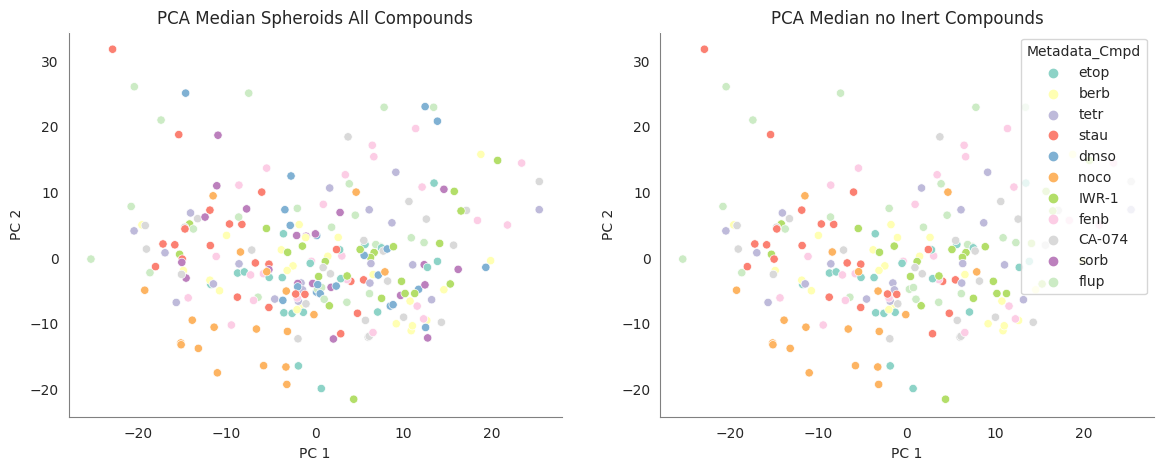

In [11]:
# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataPCA['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataPCA).set(title=f'PCA {statmet} Spheroids All Compounds'
            )


noInert = dataPCA[~(dataPCA['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=noInert).set(title=f'PCA {statmet} no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}pca.png')
plt.show()
plt.close()
del noInert

In [12]:
min_dist=0.2
spread= 5
n_epochs=None
metric='euclidean'

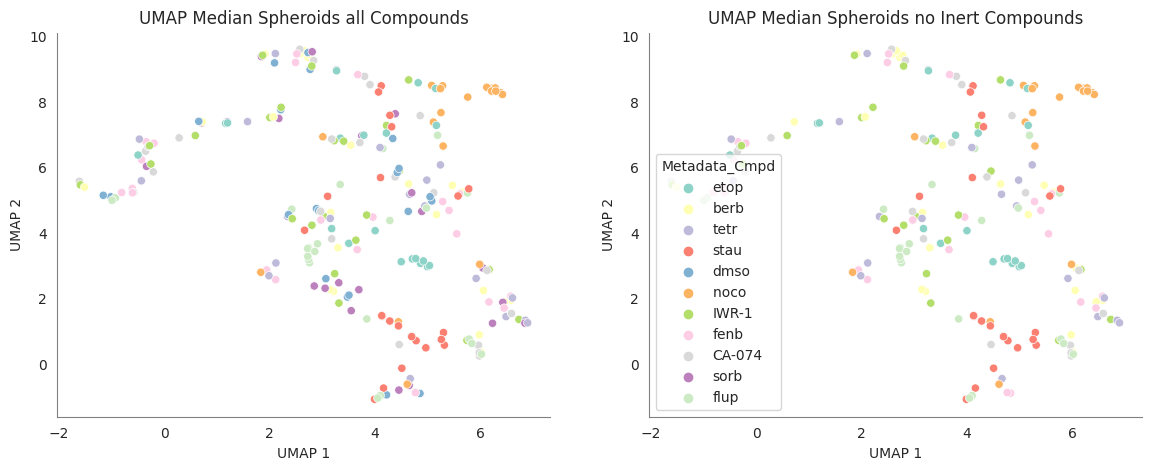

In [13]:
nn = 5
umap_model = umap.UMAP(n_neighbors=nn
                #        , min_dist=min_dist
                #        , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataUMAP).set(title=f'UMAP {statmet} Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=noInert).set(title=f'UMAP {statmet} Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}umap{nn}nn.png')
plt.show()
plt.close()

In [14]:
# xlimPCA = [training_data['pc1'].min() - 0.2*abs(training_data['pc1'].min()), training_data['pc1'].max() + 0.2*abs(training_data['pc1'].max())]
# ylimPCA = [training_data['pc2'].min() - 0.2*abs(training_data['pc2'].min()), training_data['pc2'].max() + 0.2*abs(training_data['pc2'].max())]
# xlimUMAP = [training_data['umap1'].min() - 2, training_data['umap1'].max() + 0.2*abs(training_data['umap1'].max())]
# ylimUMAP = [training_data['umap2'].min() - 2, training_data['umap2'].max() + 0.2*abs(training_data['umap2'].max())]

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


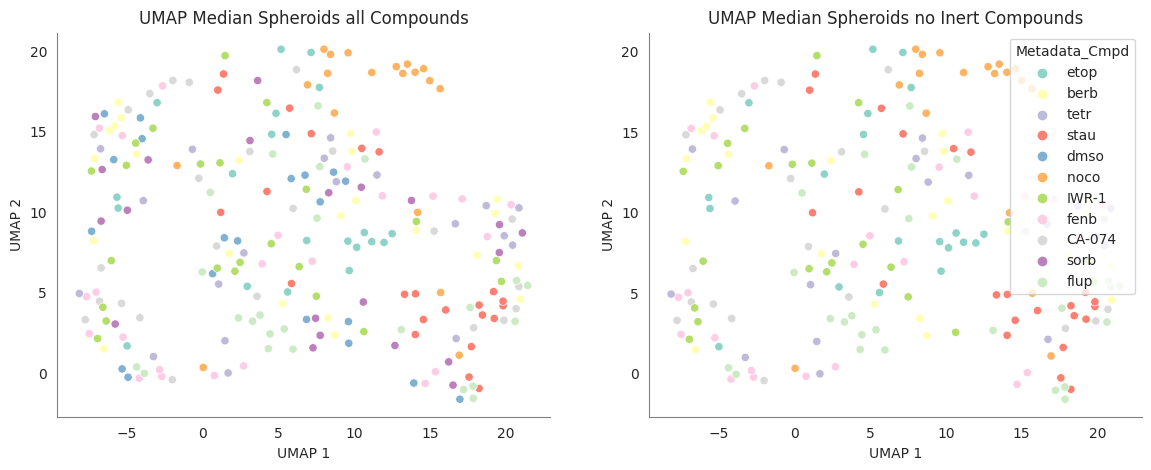

In [15]:
nn = 25
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataUMAP).set(title=f'UMAP {statmet} Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=noInert).set(title=f'UMAP {statmet} Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}umap{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


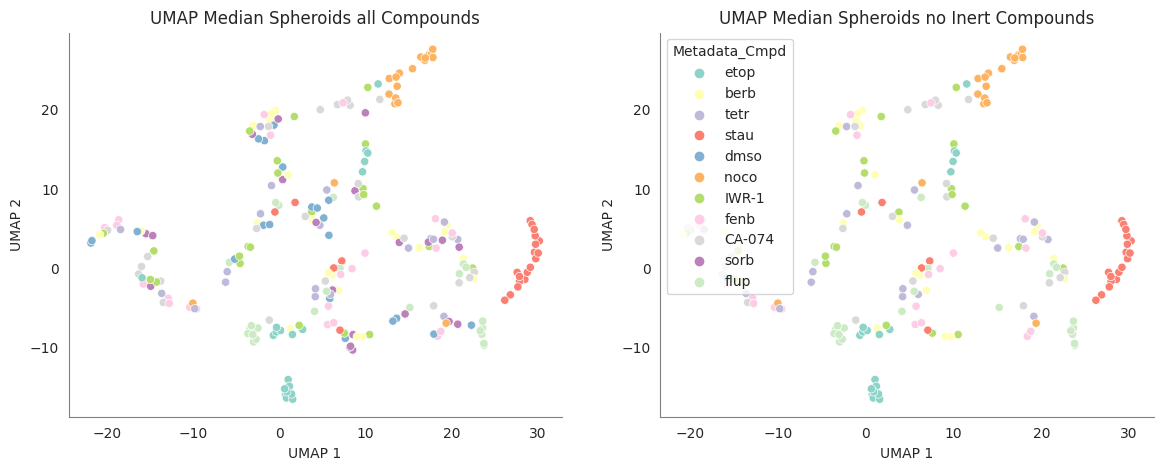

In [16]:
nn = 5
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy, y=dataUMAP['onehot'])
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataUMAP).set(title=f'UMAP {statmet} Spheroids all Compounds'
            )
noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    # marker='.',
                    data=noInert).set(title=f'UMAP {statmet} Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}umapSupervised{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


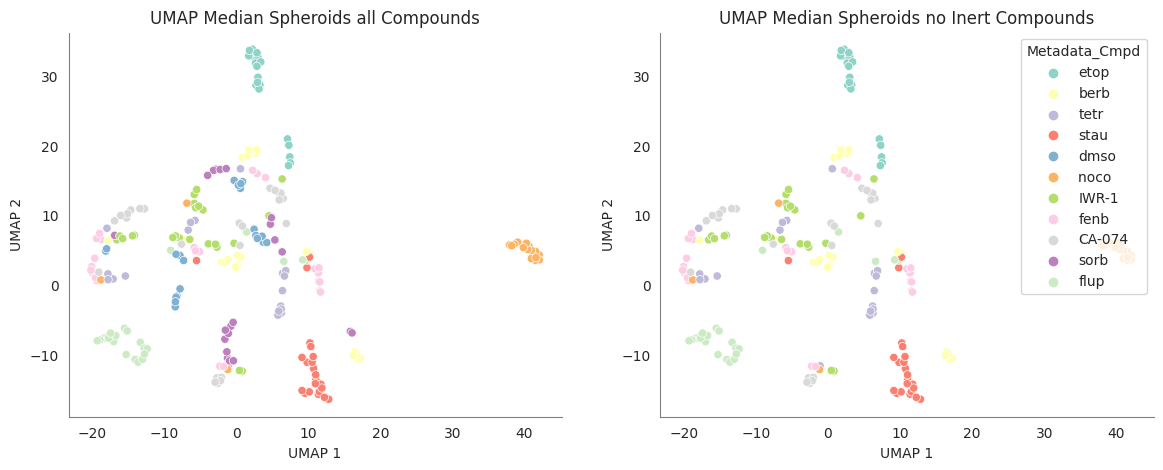

In [17]:
nn = 15
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy, y=dataUMAP['onehot'])
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataUMAP).set(title=f'UMAP {statmet} Spheroids all Compounds'
            )
noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    # marker='.',
                    data=noInert).set(title=f'UMAP {statmet} Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}umapSupervised{nn}nn.png')
plt.show()
plt.close()

In [18]:
###Means
statmet = 'Mean'
read_data = pd.read_parquet(f'{FeatureDir}/spheroid{statmet}.parquet')
cbar = pd.DataFrame()
read_data.reset_index(inplace=True, drop = True)
training_data = read_data.copy()
loc_data = training_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y']]
training_data = training_data.loc[:,~training_data.columns.str.contains('Location', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('ImageNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Parent', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Children', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_ObjectNumber', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Object_Number', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Y', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_X', case=True)]
##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]
target = pd.DataFrame()
onehot_val = list(range(len(training_data['Metadata_Cmpd'].unique())))
onehot_dict = dict(zip(training_data['Metadata_Cmpd'].unique(), onehot_val))
target['onehot'] = training_data['Metadata_Cmpd'].apply(lambda x: onehot_dict.get(x, -1))
training_data['onehot'] = target['onehot']
training_data = training_data.copy()

toNpy = training_data.loc[:,~training_data.columns.str.contains('Metadata_|onehot')]
toNpy.reset_index(inplace=True, drop=True)
toNpy = toNpy.copy()
dataNpy = toNpy.to_numpy()
colnames = toNpy.columns

dataPCA = pd.DataFrame()
dataPCA['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
dataPCA['onehot'] = training_data['onehot']

dataUMAP = pd.DataFrame()
dataUMAP['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
dataUMAP['onehot'] = training_data['onehot']

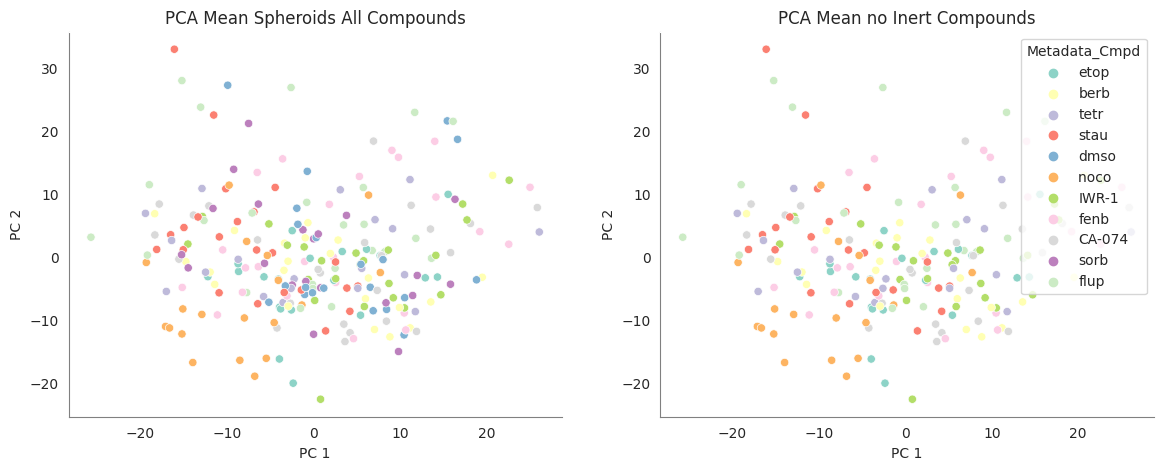

In [19]:
# perplex = 20
pca_model = PCA(n_components=  2)
pca_model = pca_model.fit(dataNpy)
pcaOut = pca_model.transform(dataNpy)
dataPCA['pc1'] = pcaOut[:,0]
dataPCA['pc2'] = pcaOut[:,1]
dataPCA = dataPCA.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataPCA['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataPCA).set(title=f'PCA {statmet} Spheroids All Compounds'
            )


noInert = dataPCA[~(dataPCA['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=noInert).set(title=f'PCA {statmet} no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}pca.png')
plt.show()
plt.close()
del noInert

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


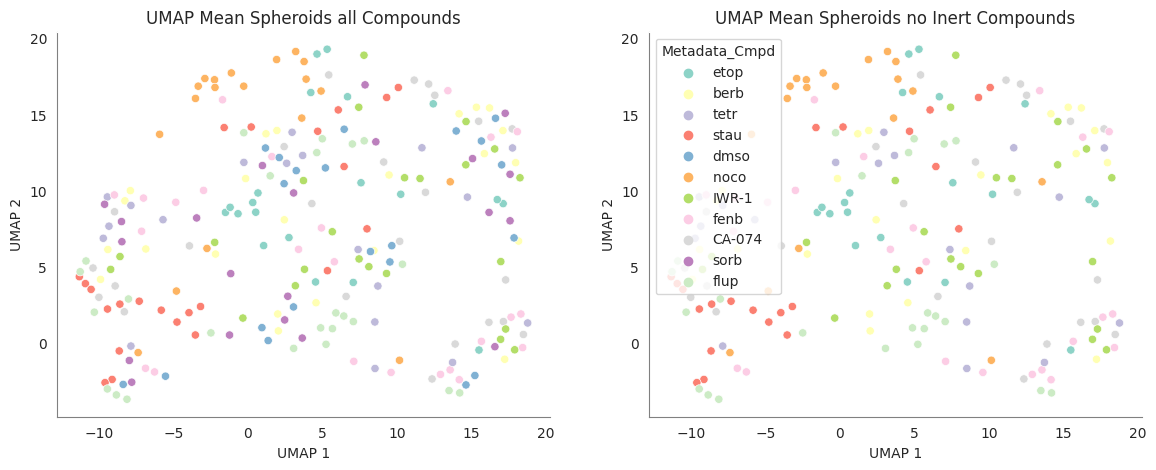

In [20]:
nn = 25
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataUMAP).set(title=f'UMAP {statmet} Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=noInert).set(title=f'UMAP {statmet} Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}umap{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


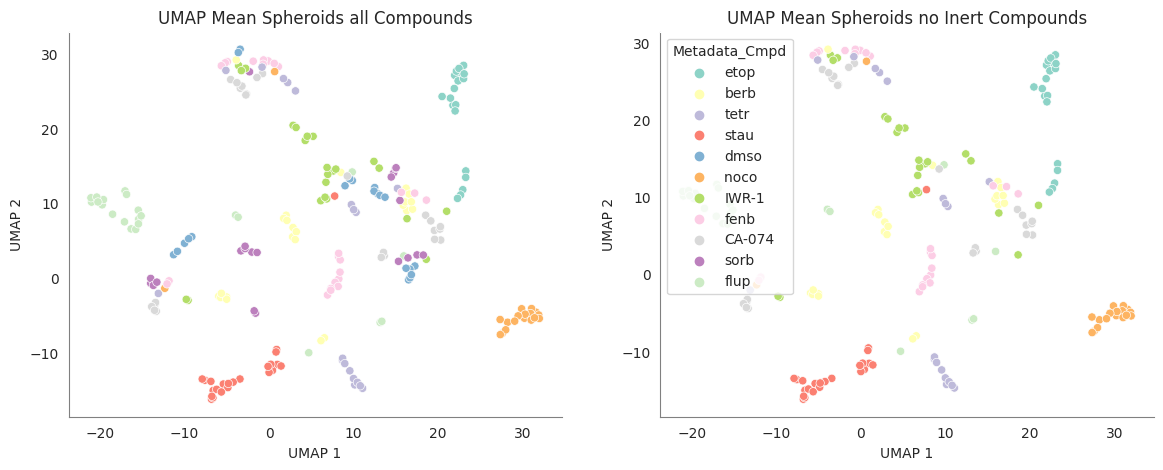

In [21]:
nn = 15
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy, y=dataUMAP['onehot'])
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=dataUMAP).set(title=f'UMAP {statmet} Spheroids all Compounds'
            )
noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                #     marker='.',
                    data=noInert).set(title=f'UMAP {statmet} Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/{statmet}umapSupervised{nn}nn.png')
plt.show()
plt.close()